In [26]:
from __future__ import print_function
#%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML
import pandas as pd
import data_utils.data_utils_celeba_pytorch5 as data_utils
import data_utils.network_tuning_valid as network_tuning
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import pickle
# Load functions
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout2d, MaxPool2d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [27]:
pwd

'/Users/MartinJohnsen/Documents/Martin Johnsen/MMC/3. Semester/Deep Learning/Projects/Algorithmic fairness/AlgorithmicFairness'

In [28]:
IMAGE_SHAPE = [73,60,3]
# Root directory for dataset
#dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'
# Paths to data
VALID_PATH = "Data/valid.csv"  
IMAGE_PATHS = "/Users/MartinJohnsen/Documents/Martin Johnsen/MMC/3. Semester/Deep Learning/Projects/Algorithmic fairness/Data/celebA_resize3"
TARGET_COL = 'Smiling' #'Smiling'
NUM_CLASSES = 2

# valid data
data_valid = data_utils.CelebADataset(VALID_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

In [29]:
attributes = pd.read_csv('Data/list_attr_celeba.txt', sep=" ")
attributes.drop('Unnamed: 41',axis=1, inplace=True)
partition = pd.read_csv('Data/list_eval_partition.txt', sep=" ", header=None, names=['im_id','partition'])
matched = attributes.set_index('im_id').join(partition.set_index('im_id')).replace(-1,0)

valid_df = matched[matched['partition']==1]

In [30]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


In [31]:
criterion = nn.CrossEntropyLoss()          #<-- Your code here.   

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

In [32]:
# Function to get label
def get_labels(batch):
    return get_variable(Variable(batch['target']))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(batch['image']))
    }

In [33]:
# Read dataframe with training metrics
df = pd.read_pickle('models/aws_models/run4_cheek__df.pkl') #e.g. pd.read_pickle('df.pkl')

In [34]:
df.loc[2,'activations']

[<function torch.nn.functional.relu(input, inplace=False)>,
 <function torch.nn.functional.relu(input, inplace=False)>,
 <function torch.nn.functional.relu(input, inplace=False)>,
 <function torch.nn.functional.relu(input, inplace=False)>]

In [35]:
df

layers                                        activations  \
2       2  [<function relu at 0x10f37ef28>, <function rel...   

   conv_out_channels  kernel_size  conv_stride  maxpool  dropout  batchnorm  \
2                 32            5            1        2      0.2       True   

  optimizer  learning_rate  weight_decay  batch_size  num_epochs  \
2      Adam          0.001          0.01         128           5   

                  net                                         train_loss  \
2  run4_cheek__model2  [0.8481726050376892, 1.1148182153701782, 1.035...   

                                          train_accs  \
2  [0.4375, 0.5625, 0.546875, 0.5390625, 0.523437...   

                                    valid_train_loss  \
2  [4.438417911529541, 0.28789761662483215, 0.254...   

                                    valid_train_accs valid_loss valid_accs  
2  [0.45895203948020935, 0.8807570338249207, 0.89...    0.21339    0.90985

In [36]:
np.mean(df.loc[2,'train_accs'][-300:])

0.8779658565918604

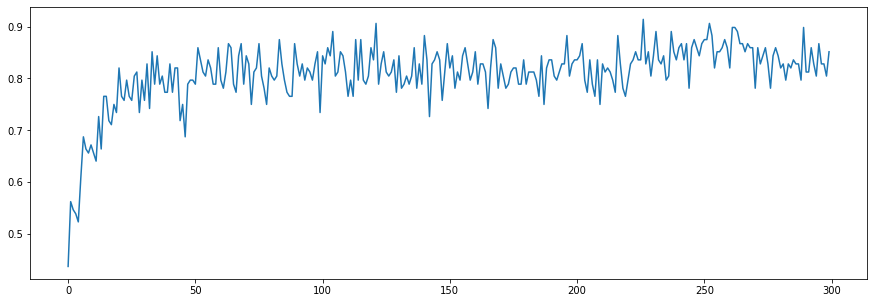

In [37]:
plt.figure(figsize=(15,5))
plt.plot(df.loc[2,'train_accs'][0:300])
ind = [300*i for i in range(0,22)]
#plt.plot(ind,df.loc[3,'valid_train_accs'])

ValueError: x and y must have same first dimension, but have shapes (22,) and (36,)

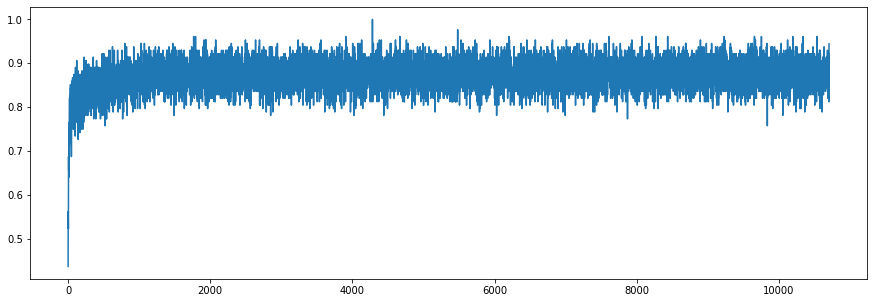

In [38]:
plt.figure(figsize=(15,5))
plt.plot(df.loc[2,'train_accs'])
ind = [300*i for i in range(0,22)]
plt.plot(ind,df.loc[2,'valid_train_accs'])

In [39]:
# Change i to the model number you want to load
i = 2
IMAGE_SHAPE = [73,60,3]
layers = df.loc[i,'layers']
activations = df.loc[i,'activations']
conv_out_channels = df.loc[i,'conv_out_channels']
kernel_size = df.loc[i,'kernel_size']
conv_stride = df.loc[i,'conv_stride']
maxpool = int(df.loc[i,'maxpool'])
dropout = df.loc[i,'dropout']
batchnorm = df.loc[i,'batchnorm']
optimizer = df.loc[i,'optimizer']
learning_rate = df.loc[i,'learning_rate']
weight_decay = df.loc[i,'weight_decay']
batch_size = int(df.loc[i,'batch_size'])
num_epochs = df.loc[i,'num_epochs']

net = network_tuning.tune_architecture(layers, activations, IMAGE_SHAPE, conv_out_channels, kernel_size,conv_stride, maxpool, dropout, batchnorm)

In [40]:
# Load network, choose the model i
net.load_state_dict(torch.load('models/aws_models/run4_cheek__model2.dms',map_location=torch.device('cpu'))) # e.g. net.load_state_dict(torch.load('model1'))
net.eval()

Net(
  (conv_1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (l_out): Linear(in_features=11520, out_features=2, bias=False)
)

In [41]:
#dataframe for saving predictions
valid_predictions = valid_df.astype(object)
valid_predictions.loc[:,'target'] = valid_predictions.loc[:,'Smiling']
valid_predictions.drop(['Smiling','partition'],axis=1)
valid_predictions['output'] = np.nan
valid_predictions['labels_argmax'] = np.nan
valid_predictions['accuracy'] = np.nan
valid_predictions['criterion'] = np.nan

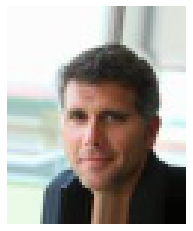

True Label:  tensor(0)
Model output:  tensor([ 0.6695, -0.6695])
File name:  173974.jpg


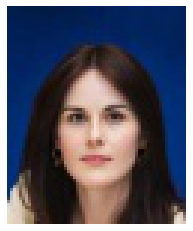

True Label:  tensor(0)
Model output:  tensor([ 1.7917, -1.7911])
File name:  169606.jpg


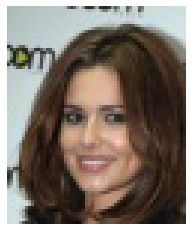

True Label:  tensor(1)
Model output:  tensor([-3.1668,  3.1670])
File name:  174757.jpg


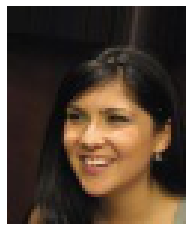

True Label:  tensor(1)
Model output:  tensor([-5.2397,  5.2397])
File name:  176761.jpg


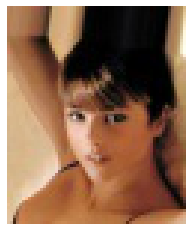

True Label:  tensor(0)
Model output:  tensor([ 1.4809, -1.4807])
File name:  164503.jpg


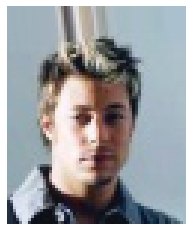

True Label:  tensor(0)
Model output:  tensor([ 2.7598, -2.7597])
File name:  178177.jpg


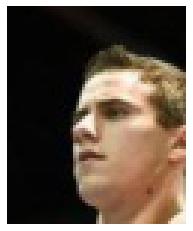

True Label:  tensor(0)
Model output:  tensor([ 2.4440, -2.4433])
File name:  176467.jpg


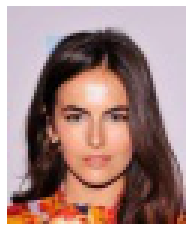

True Label:  tensor(0)
Model output:  tensor([ 1.5440, -1.5437])
File name:  175633.jpg


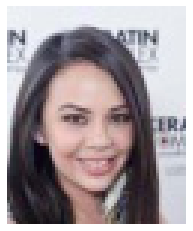

True Label:  tensor(1)
Model output:  tensor([-3.3917,  3.3916])
File name:  166598.jpg


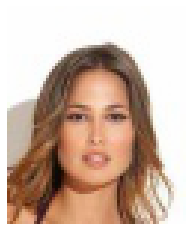

True Label:  tensor(0)
Model output:  tensor([ 1.3467, -1.3464])
File name:  181011.jpg


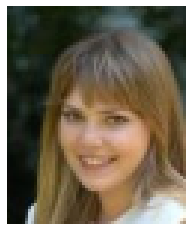

True Label:  tensor(1)
Model output:  tensor([-3.5369,  3.5372])
File name:  175826.jpg


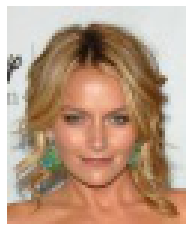

True Label:  tensor(1)
Model output:  tensor([-1.3001,  1.3006])
File name:  172129.jpg


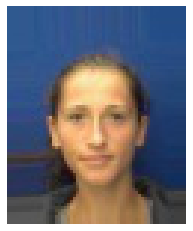

True Label:  tensor(0)
Model output:  tensor([ 1.7487, -1.7483])
File name:  180415.jpg


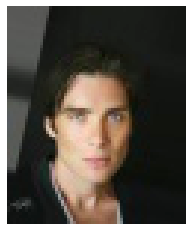

True Label:  tensor(0)
Model output:  tensor([ 2.6806, -2.6803])
File name:  174629.jpg


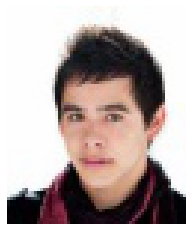

True Label:  tensor(0)
Model output:  tensor([-0.1287,  0.1293])
File name:  176489.jpg


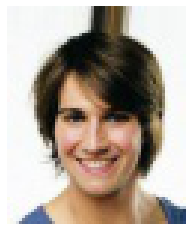

True Label:  tensor(1)
Model output:  tensor([-5.0757,  5.0761])
File name:  171827.jpg


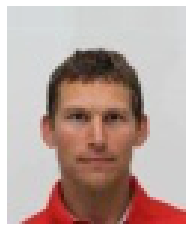

True Label:  tensor(0)
Model output:  tensor([ 1.8977, -1.8973])
File name:  174002.jpg


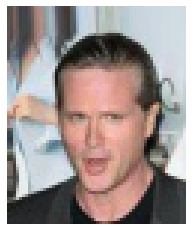

True Label:  tensor(0)
Model output:  tensor([ 0.3999, -0.3994])
File name:  168283.jpg


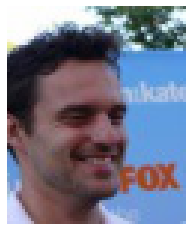

True Label:  tensor(1)
Model output:  tensor([-2.0077,  2.0076])
File name:  174830.jpg


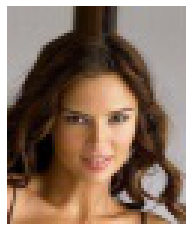

True Label:  tensor(0)
Model output:  tensor([-0.6991,  0.6994])
File name:  169059.jpg


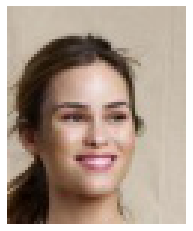

True Label:  tensor(1)
Model output:  tensor([-4.3276,  4.3278])
File name:  178059.jpg


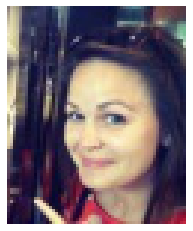

True Label:  tensor(1)
Model output:  tensor([-1.6792,  1.6797])
File name:  175570.jpg


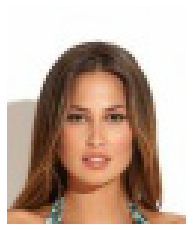

True Label:  tensor(0)
Model output:  tensor([ 1.2061, -1.2059])
File name:  167570.jpg


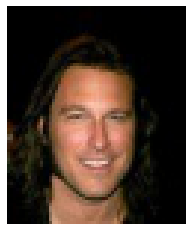

True Label:  tensor(1)
Model output:  tensor([-2.9261,  2.9260])
File name:  163050.jpg


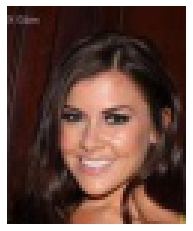

True Label:  tensor(1)
Model output:  tensor([-4.2800,  4.2803])
File name:  170439.jpg


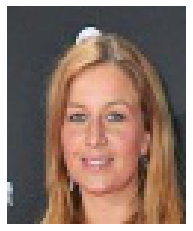

True Label:  tensor(1)
Model output:  tensor([-1.5653,  1.5657])
File name:  177700.jpg


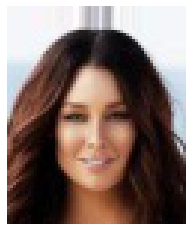

True Label:  tensor(1)
Model output:  tensor([-3.1852,  3.1853])
File name:  163485.jpg


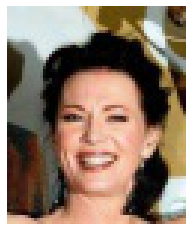

True Label:  tensor(1)
Model output:  tensor([-4.9589,  4.9593])
File name:  173784.jpg


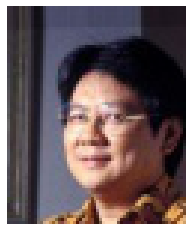

True Label:  tensor(1)
Model output:  tensor([-0.2674,  0.2680])
File name:  181567.jpg


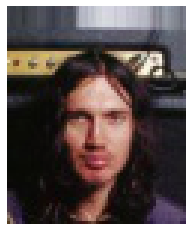

True Label:  tensor(0)
Model output:  tensor([ 1.0133, -1.0133])
File name:  177775.jpg


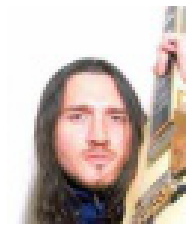

True Label:  tensor(0)
Model output:  tensor([ 2.0928, -2.0928])
File name:  173016.jpg


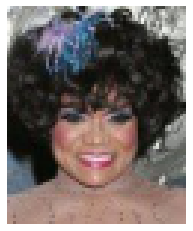

True Label:  tensor(1)
Model output:  tensor([-2.0540,  2.0544])
File name:  163261.jpg


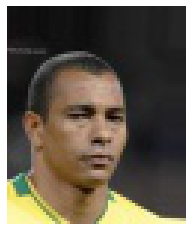

True Label:  tensor(0)
Model output:  tensor([ 3.5690, -3.5689])
File name:  167152.jpg


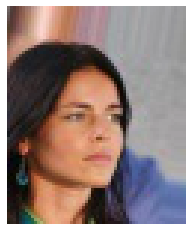

True Label:  tensor(0)
Model output:  tensor([ 2.4676, -2.4673])
File name:  167328.jpg


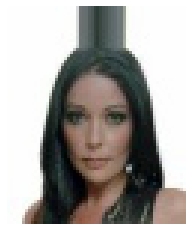

True Label:  tensor(0)
Model output:  tensor([ 1.9779, -1.9776])
File name:  181240.jpg


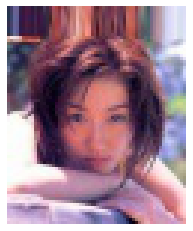

True Label:  tensor(0)
Model output:  tensor([-0.2255,  0.2253])
File name:  163747.jpg


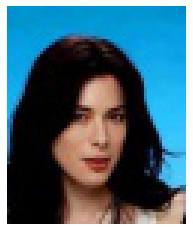

True Label:  tensor(0)
Model output:  tensor([ 1.2267, -1.2264])
File name:  168098.jpg


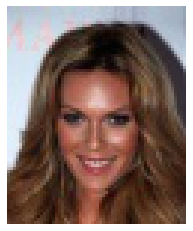

True Label:  tensor(1)
Model output:  tensor([-3.8719,  3.8719])
File name:  173987.jpg


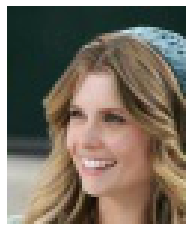

True Label:  tensor(1)
Model output:  tensor([-1.6967,  1.6968])
File name:  181665.jpg


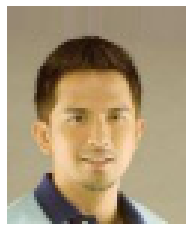

True Label:  tensor(0)
Model output:  tensor([ 0.7970, -0.7967])
File name:  165872.jpg


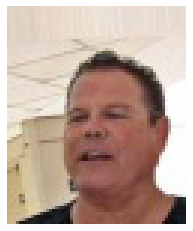

True Label:  tensor(0)
Model output:  tensor([ 1.0010, -1.0005])
File name:  174052.jpg


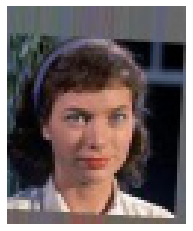

True Label:  tensor(0)
Model output:  tensor([ 0.6612, -0.6612])
File name:  170923.jpg


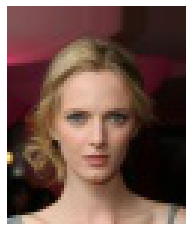

True Label:  tensor(0)
Model output:  tensor([ 2.7267, -2.7265])
File name:  175603.jpg


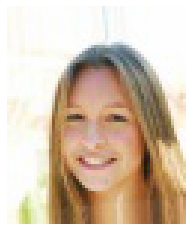

True Label:  tensor(1)
Model output:  tensor([-4.6321,  4.6325])
File name:  175512.jpg


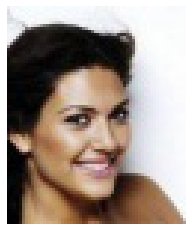

True Label:  tensor(1)
Model output:  tensor([-3.5345,  3.5348])
File name:  176606.jpg


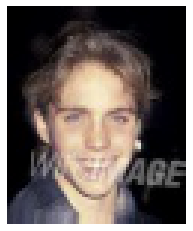

True Label:  tensor(1)
Model output:  tensor([-2.7658,  2.7658])
File name:  164446.jpg


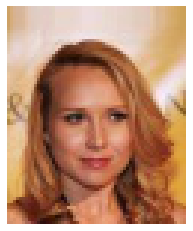

True Label:  tensor(1)
Model output:  tensor([ 0.4368, -0.4365])
File name:  178714.jpg


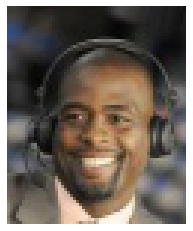

True Label:  tensor(1)
Model output:  tensor([-2.0869,  2.0870])
File name:  163246.jpg


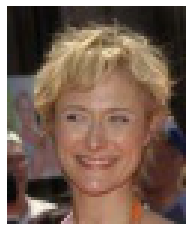

True Label:  tensor(1)
Model output:  tensor([-3.2847,  3.2849])
File name:  169181.jpg


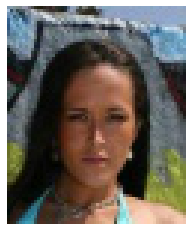

True Label:  tensor(0)
Model output:  tensor([ 1.3766, -1.3763])
File name:  170862.jpg


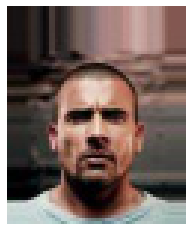

True Label:  tensor(0)
Model output:  tensor([ 1.9732, -1.9733])
File name:  179402.jpg


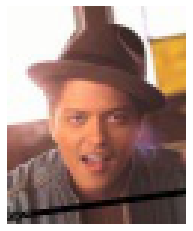

True Label:  tensor(0)
Model output:  tensor([-1.5725,  1.5725])
File name:  165462.jpg


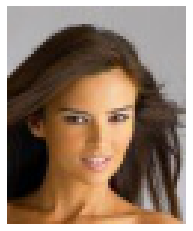

True Label:  tensor(0)
Model output:  tensor([-0.2437,  0.2440])
File name:  178368.jpg


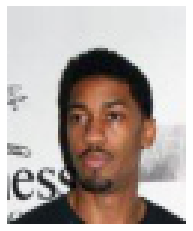

True Label:  tensor(0)
Model output:  tensor([ 2.7148, -2.7148])
File name:  166481.jpg


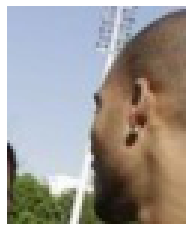

True Label:  tensor(0)
Model output:  tensor([ 1.9153, -1.9154])
File name:  165868.jpg


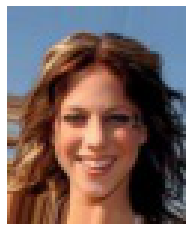

True Label:  tensor(1)
Model output:  tensor([-3.6596,  3.6596])
File name:  164994.jpg


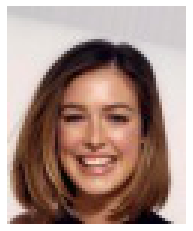

True Label:  tensor(1)
Model output:  tensor([-6.1731,  6.1730])
File name:  177073.jpg


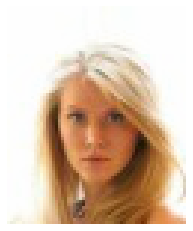

True Label:  tensor(0)
Model output:  tensor([ 2.0508, -2.0505])
File name:  171348.jpg


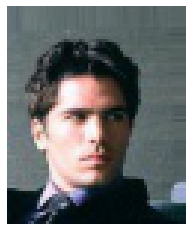

True Label:  tensor(0)
Model output:  tensor([ 3.5340, -3.5341])
File name:  167186.jpg


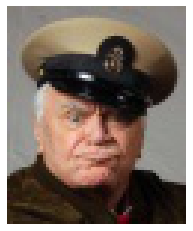

True Label:  tensor(0)
Model output:  tensor([ 0.6898, -0.6897])
File name:  170268.jpg


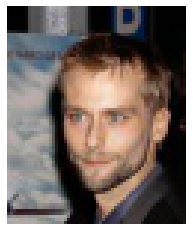

True Label:  tensor(0)
Model output:  tensor([ 0.9543, -0.9542])
File name:  180740.jpg


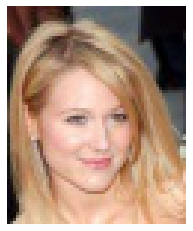

True Label:  tensor(1)
Model output:  tensor([-2.1465,  2.1469])
File name:  178281.jpg


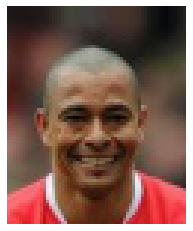

True Label:  tensor(1)
Model output:  tensor([-1.9855,  1.9855])
File name:  173380.jpg


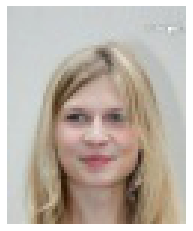

True Label:  tensor(1)
Model output:  tensor([-0.7009,  0.7013])
File name:  177651.jpg


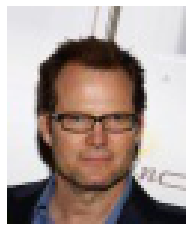

True Label:  tensor(0)
Model output:  tensor([ 0.5365, -0.5366])
File name:  171302.jpg


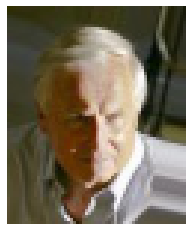

True Label:  tensor(0)
Model output:  tensor([ 0.9730, -0.9727])
File name:  163756.jpg


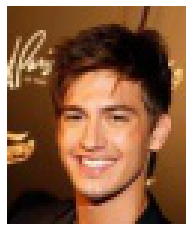

True Label:  tensor(1)
Model output:  tensor([-5.0458,  5.0458])
File name:  165888.jpg


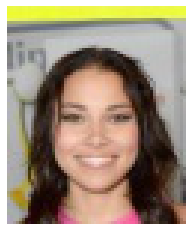

True Label:  tensor(1)
Model output:  tensor([-3.8699,  3.8702])
File name:  176656.jpg


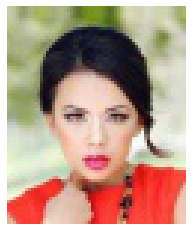

True Label:  tensor(0)
Model output:  tensor([ 3.6364, -3.6361])
File name:  166832.jpg


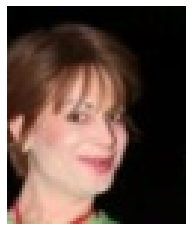

True Label:  tensor(1)
Model output:  tensor([-0.8688,  0.8690])
File name:  168768.jpg


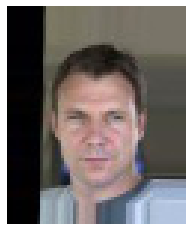

True Label:  tensor(0)
Model output:  tensor([ 1.2578, -1.2573])
File name:  162978.jpg


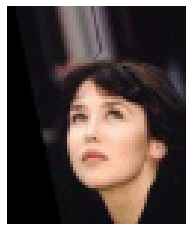

True Label:  tensor(0)
Model output:  tensor([ 2.5973, -2.5969])
File name:  164837.jpg


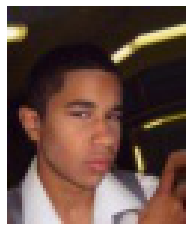

True Label:  tensor(0)
Model output:  tensor([ 1.4979, -1.4979])
File name:  163133.jpg


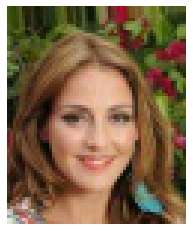

True Label:  tensor(1)
Model output:  tensor([-3.8198,  3.8199])
File name:  181451.jpg


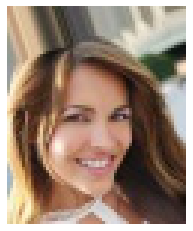

True Label:  tensor(1)
Model output:  tensor([-2.5639,  2.5640])
File name:  170516.jpg


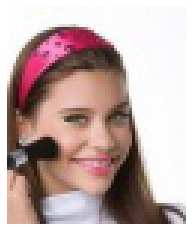

True Label:  tensor(1)
Model output:  tensor([-2.7026,  2.7024])
File name:  167318.jpg


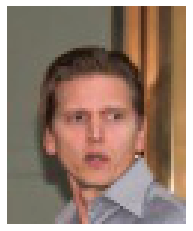

True Label:  tensor(0)
Model output:  tensor([ 3.3730, -3.3725])
File name:  176235.jpg


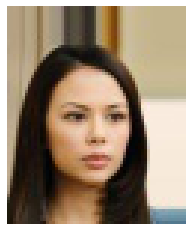

True Label:  tensor(0)
Model output:  tensor([ 3.3297, -3.3297])
File name:  166850.jpg


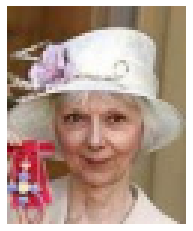

True Label:  tensor(1)
Model output:  tensor([-0.7470,  0.7473])
File name:  173007.jpg


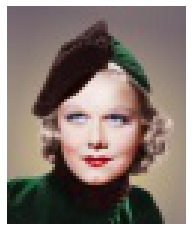

True Label:  tensor(0)
Model output:  tensor([ 0.1910, -0.1908])
File name:  171928.jpg


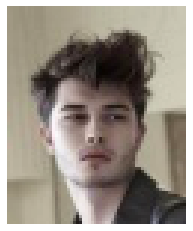

True Label:  tensor(0)
Model output:  tensor([ 2.4100, -2.4097])
File name:  167559.jpg


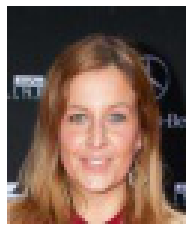

True Label:  tensor(1)
Model output:  tensor([-2.1300,  2.1305])
File name:  171278.jpg


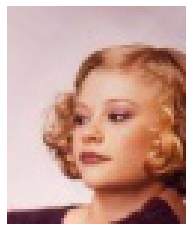

True Label:  tensor(1)
Model output:  tensor([ 1.8115, -1.8108])
File name:  163430.jpg


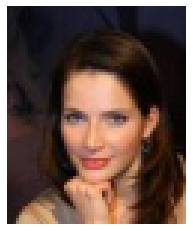

True Label:  tensor(0)
Model output:  tensor([ 0.1106, -0.1104])
File name:  179686.jpg


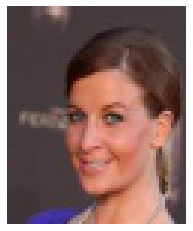

True Label:  tensor(1)
Model output:  tensor([-2.5627,  2.5630])
File name:  181329.jpg


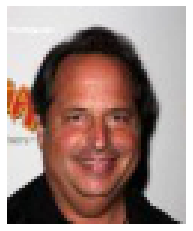

True Label:  tensor(1)
Model output:  tensor([-2.7815,  2.7815])
File name:  165259.jpg


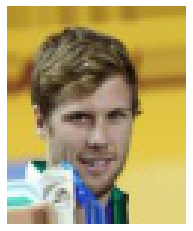

True Label:  tensor(1)
Model output:  tensor([ 0.4907, -0.4905])
File name:  173824.jpg


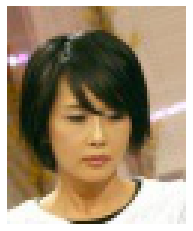

True Label:  tensor(0)
Model output:  tensor([ 3.0110, -3.0108])
File name:  167990.jpg


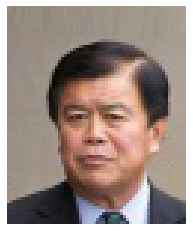

True Label:  tensor(0)
Model output:  tensor([ 1.4049, -1.4047])
File name:  174666.jpg


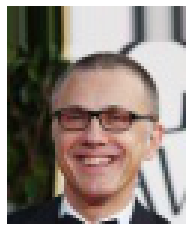

True Label:  tensor(1)
Model output:  tensor([-4.4554,  4.4556])
File name:  175727.jpg


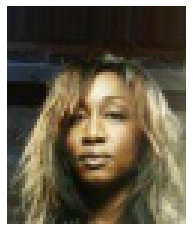

True Label:  tensor(0)
Model output:  tensor([ 2.5497, -2.5497])
File name:  173910.jpg


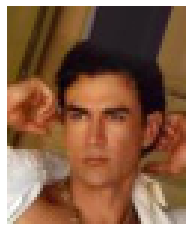

True Label:  tensor(0)
Model output:  tensor([ 2.2889, -2.2885])
File name:  170904.jpg


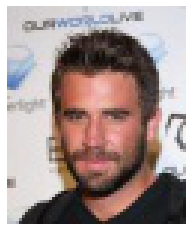

True Label:  tensor(0)
Model output:  tensor([ 1.3706, -1.3707])
File name:  169930.jpg


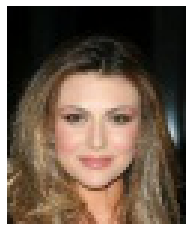

True Label:  tensor(1)
Model output:  tensor([-1.2007,  1.2013])
File name:  181843.jpg


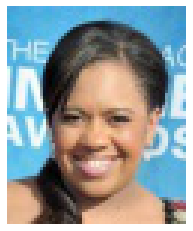

True Label:  tensor(1)
Model output:  tensor([-4.4222,  4.4224])
File name:  177388.jpg


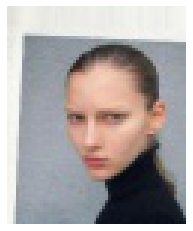

True Label:  tensor(0)
Model output:  tensor([ 2.4398, -2.4398])
File name:  163450.jpg


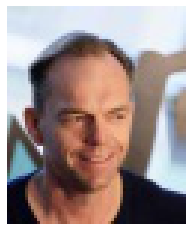

True Label:  tensor(1)
Model output:  tensor([-1.2171,  1.2176])
File name:  169029.jpg


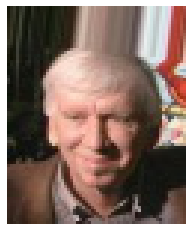

True Label:  tensor(1)
Model output:  tensor([-0.6831,  0.6830])
File name:  169222.jpg


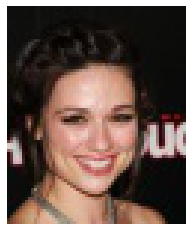

True Label:  tensor(1)
Model output:  tensor([-4.6202,  4.6200])
File name:  168005.jpg


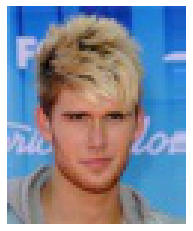

True Label:  tensor(0)
Model output:  tensor([ 1.0996, -1.0993])
File name:  168442.jpg


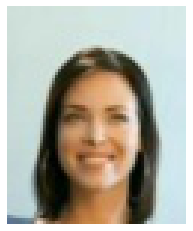

True Label:  tensor(1)
Model output:  tensor([-2.6349,  2.6352])
File name:  167701.jpg


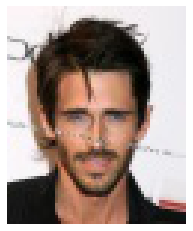

True Label:  tensor(0)
Model output:  tensor([ 0.5698, -0.5696])
File name:  164839.jpg


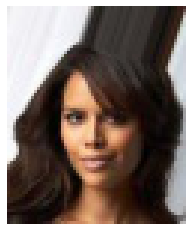

True Label:  tensor(0)
Model output:  tensor([ 0.3716, -0.3715])
File name:  182288.jpg


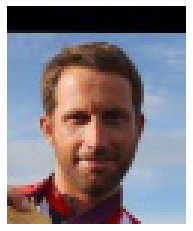

True Label:  tensor(1)
Model output:  tensor([-0.1300,  0.1298])
File name:  172349.jpg


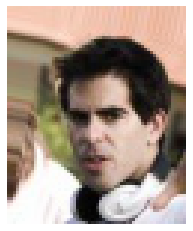

True Label:  tensor(0)
Model output:  tensor([ 2.6650, -2.6649])
File name:  163960.jpg


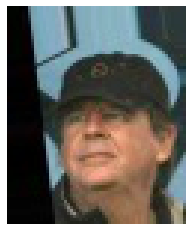

True Label:  tensor(0)
Model output:  tensor([ 1.6455, -1.6451])
File name:  175685.jpg


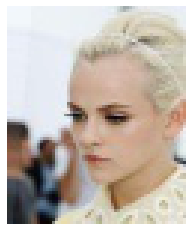

True Label:  tensor(0)
Model output:  tensor([ 1.9764, -1.9758])
File name:  164355.jpg


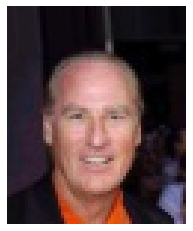

True Label:  tensor(1)
Model output:  tensor([-1.4559,  1.4560])
File name:  171358.jpg


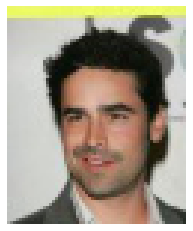

True Label:  tensor(1)
Model output:  tensor([-1.9188,  1.9191])
File name:  171295.jpg


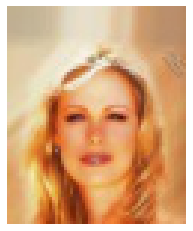

True Label:  tensor(0)
Model output:  tensor([ 0.5181, -0.5175])
File name:  176034.jpg


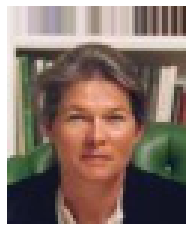

True Label:  tensor(0)
Model output:  tensor([ 0.7080, -0.7076])
File name:  172092.jpg


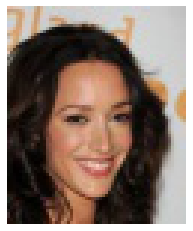

True Label:  tensor(1)
Model output:  tensor([-3.4501,  3.4499])
File name:  181887.jpg


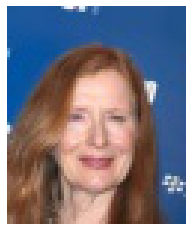

True Label:  tensor(1)
Model output:  tensor([-2.6643,  2.6646])
File name:  167661.jpg


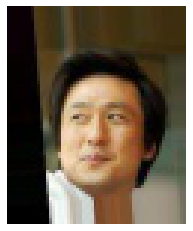

True Label:  tensor(1)
Model output:  tensor([ 1.7526, -1.7522])
File name:  171985.jpg


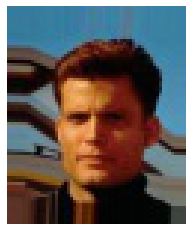

True Label:  tensor(0)
Model output:  tensor([ 2.0953, -2.0953])
File name:  167586.jpg


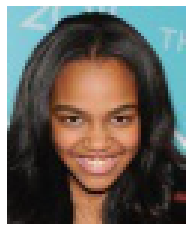

True Label:  tensor(1)
Model output:  tensor([-3.3283,  3.3283])
File name:  175519.jpg


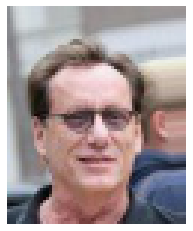

True Label:  tensor(1)
Model output:  tensor([-0.9126,  0.9130])
File name:  166112.jpg


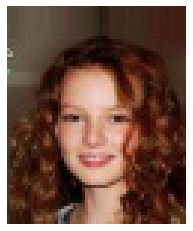

True Label:  tensor(1)
Model output:  tensor([-0.9639,  0.9641])
File name:  173486.jpg


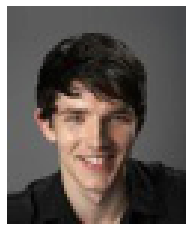

True Label:  tensor(1)
Model output:  tensor([-2.8340,  2.8340])
File name:  168340.jpg


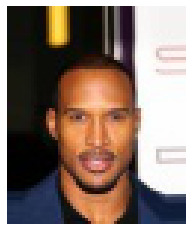

True Label:  tensor(0)
Model output:  tensor([ 0.5343, -0.5346])
File name:  171363.jpg


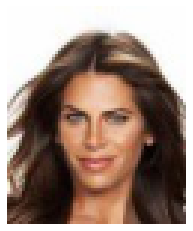

True Label:  tensor(1)
Model output:  tensor([-1.1066,  1.1072])
File name:  168332.jpg


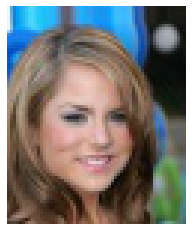

True Label:  tensor(1)
Model output:  tensor([-2.6282,  2.6281])
File name:  177108.jpg


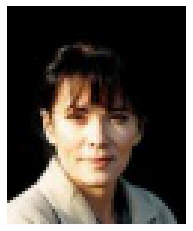

True Label:  tensor(0)
Model output:  tensor([ 1.0066, -1.0066])
File name:  170055.jpg


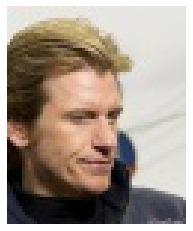

True Label:  tensor(0)
Model output:  tensor([-0.3365,  0.3364])
File name:  176370.jpg


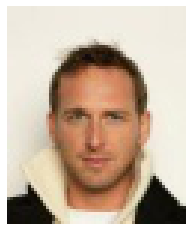

True Label:  tensor(0)
Model output:  tensor([ 0.9437, -0.9433])
File name:  163763.jpg


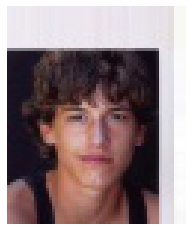

True Label:  tensor(0)
Model output:  tensor([ 1.0260, -1.0258])
File name:  168307.jpg


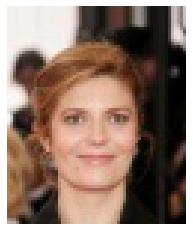

True Label:  tensor(1)
Model output:  tensor([-1.3518,  1.3523])
File name:  180510.jpg


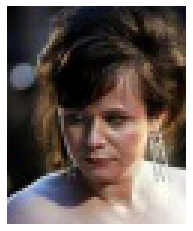

True Label:  tensor(0)
Model output:  tensor([ 1.3905, -1.3899])
File name:  165086.jpg


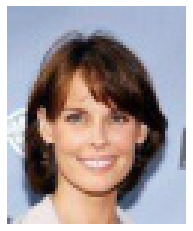

True Label:  tensor(1)
Model output:  tensor([-3.7317,  3.7317])
File name:  168111.jpg


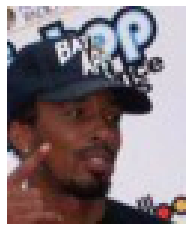

True Label:  tensor(0)
Model output:  tensor([ 0.1378, -0.1379])
File name:  166963.jpg


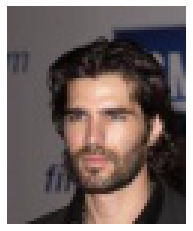

True Label:  tensor(0)
Model output:  tensor([ 1.6571, -1.6572])
File name:  166603.jpg


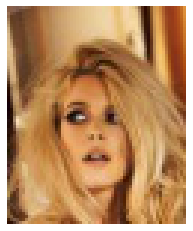

True Label:  tensor(0)
Model output:  tensor([ 2.0525, -2.0519])
File name:  172219.jpg


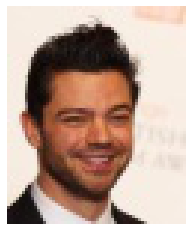

True Label:  tensor(1)
Model output:  tensor([-2.1819,  2.1819])
File name:  170866.jpg


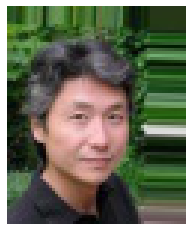

True Label:  tensor(0)
Model output:  tensor([ 1.4343, -1.4343])
File name:  167038.jpg


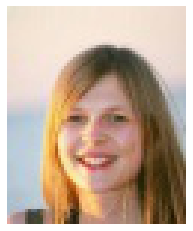

True Label:  tensor(1)
Model output:  tensor([-5.4446,  5.4448])
File name:  169499.jpg


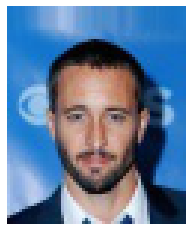

True Label:  tensor(0)
Model output:  tensor([ 1.4791, -1.4792])
File name:  177205.jpg


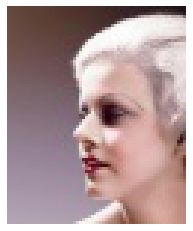

True Label:  tensor(0)
Model output:  tensor([ 1.5997, -1.5996])
File name:  169077.jpg


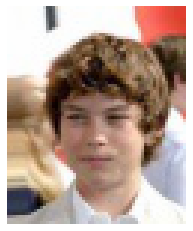

True Label:  tensor(0)
Model output:  tensor([ 0.6011, -0.6005])
File name:  176899.jpg


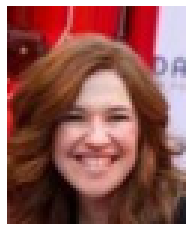

True Label:  tensor(1)
Model output:  tensor([-5.5086,  5.5087])
File name:  164567.jpg


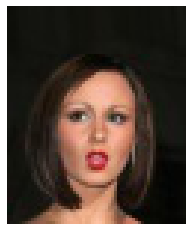

True Label:  tensor(0)
Model output:  tensor([ 3.1535, -3.1532])
File name:  173046.jpg


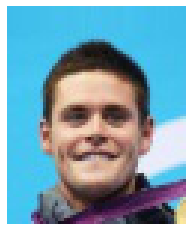

True Label:  tensor(1)
Model output:  tensor([-0.6265,  0.6269])
File name:  167040.jpg


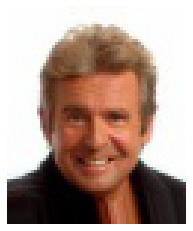

True Label:  tensor(1)
Model output:  tensor([-2.7359,  2.7362])
File name:  174847.jpg


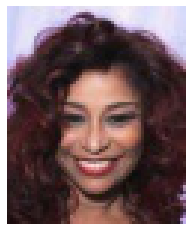

True Label:  tensor(1)
Model output:  tensor([-4.4786,  4.4787])
File name:  165300.jpg


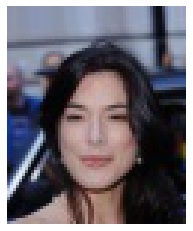

True Label:  tensor(0)
Model output:  tensor([-0.7665,  0.7667])
File name:  178079.jpg


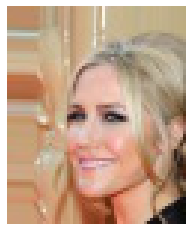

True Label:  tensor(1)
Model output:  tensor([-3.0880,  3.0886])
File name:  180478.jpg


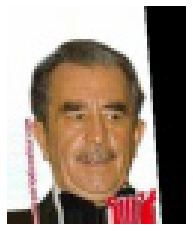

True Label:  tensor(0)
Model output:  tensor([-0.9475,  0.9478])
File name:  165205.jpg


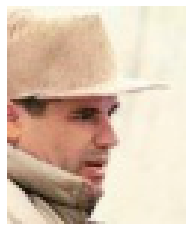

True Label:  tensor(0)
Model output:  tensor([ 2.7598, -2.7600])
File name:  163477.jpg


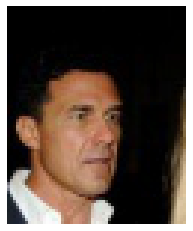

True Label:  tensor(0)
Model output:  tensor([ 0.9853, -0.9851])
File name:  170209.jpg


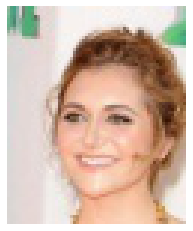

True Label:  tensor(1)
Model output:  tensor([-3.3032,  3.3037])
File name:  165769.jpg


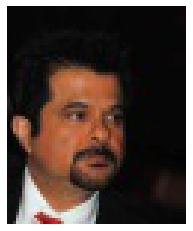

True Label:  tensor(0)
Model output:  tensor([ 2.3657, -2.3657])
File name:  166805.jpg


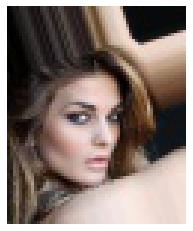

True Label:  tensor(0)
Model output:  tensor([ 2.7542, -2.7542])
File name:  181753.jpg


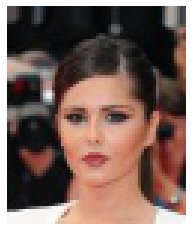

True Label:  tensor(0)
Model output:  tensor([ 2.9666, -2.9659])
File name:  164112.jpg


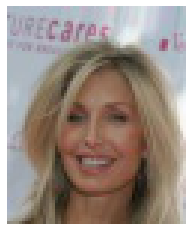

True Label:  tensor(1)
Model output:  tensor([-3.3949,  3.3950])
File name:  169756.jpg


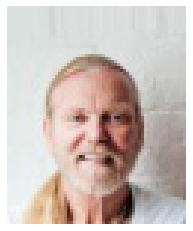

True Label:  tensor(1)
Model output:  tensor([-1.2168,  1.2171])
File name:  168306.jpg


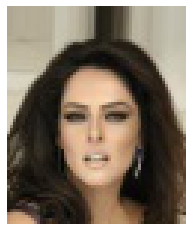

True Label:  tensor(0)
Model output:  tensor([ 1.3186, -1.3181])
File name:  167440.jpg


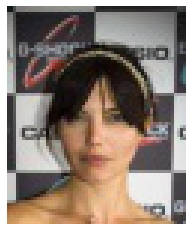

True Label:  tensor(0)
Model output:  tensor([ 1.1794, -1.1791])
File name:  174962.jpg


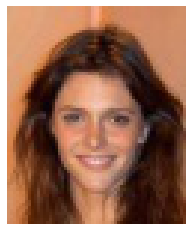

True Label:  tensor(1)
Model output:  tensor([-3.6236,  3.6238])
File name:  164634.jpg


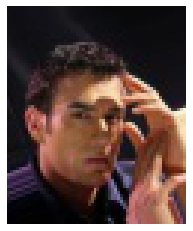

True Label:  tensor(0)
Model output:  tensor([ 2.4356, -2.4359])
File name:  174211.jpg


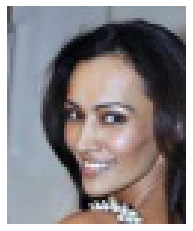

True Label:  tensor(1)
Model output:  tensor([-1.9591,  1.9591])
File name:  172122.jpg


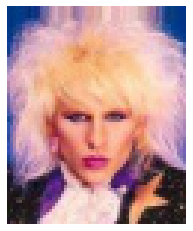

True Label:  tensor(0)
Model output:  tensor([ 3.6036, -3.6033])
File name:  180775.jpg


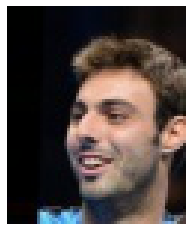

True Label:  tensor(1)
Model output:  tensor([-1.8277,  1.8277])
File name:  176791.jpg


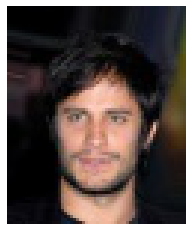

True Label:  tensor(0)
Model output:  tensor([-0.2590,  0.2591])
File name:  178137.jpg


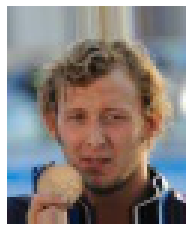

True Label:  tensor(0)
Model output:  tensor([ 0.4008, -0.4007])
File name:  176565.jpg


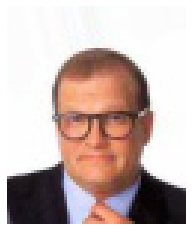

True Label:  tensor(0)
Model output:  tensor([ 1.7172, -1.7166])
File name:  166733.jpg


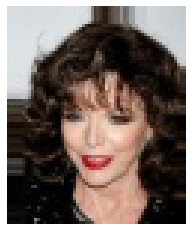

True Label:  tensor(1)
Model output:  tensor([-1.7423,  1.7427])
File name:  172627.jpg


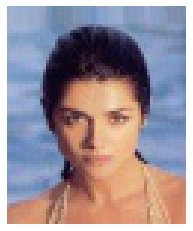

True Label:  tensor(0)
Model output:  tensor([ 1.7473, -1.7468])
File name:  169013.jpg


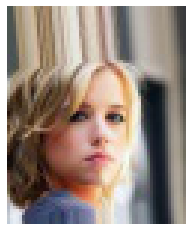

True Label:  tensor(0)
Model output:  tensor([ 2.5858, -2.5851])
File name:  172531.jpg


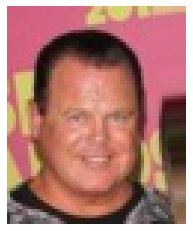

True Label:  tensor(0)
Model output:  tensor([-1.6969,  1.6972])
File name:  179287.jpg


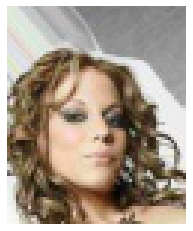

True Label:  tensor(0)
Model output:  tensor([ 0.4978, -0.4975])
File name:  164138.jpg


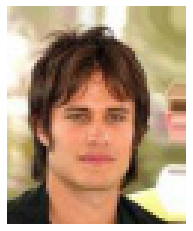

True Label:  tensor(0)
Model output:  tensor([ 1.7973, -1.7970])
File name:  169505.jpg


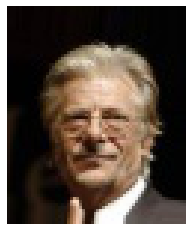

True Label:  tensor(0)
Model output:  tensor([ 0.1635, -0.1634])
File name:  166277.jpg


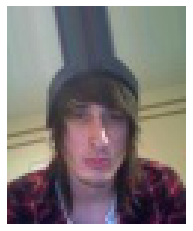

True Label:  tensor(0)
Model output:  tensor([ 1.5254, -1.5252])
File name:  171581.jpg


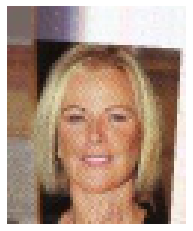

True Label:  tensor(1)
Model output:  tensor([-1.7929,  1.7935])
File name:  165134.jpg


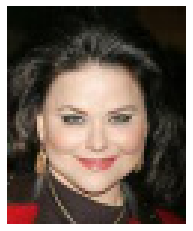

True Label:  tensor(1)
Model output:  tensor([-4.0922,  4.0926])
File name:  165308.jpg


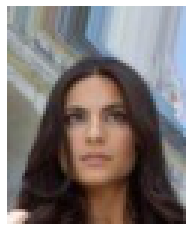

True Label:  tensor(0)
Model output:  tensor([ 2.5802, -2.5800])
File name:  180034.jpg


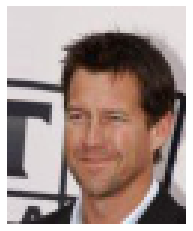

True Label:  tensor(1)
Model output:  tensor([-0.4513,  0.4516])
File name:  165395.jpg


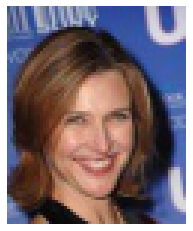

True Label:  tensor(1)
Model output:  tensor([-4.3217,  4.3216])
File name:  182034.jpg


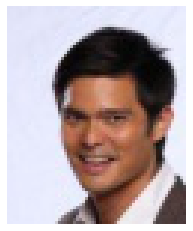

True Label:  tensor(1)
Model output:  tensor([-1.9427,  1.9430])
File name:  176038.jpg


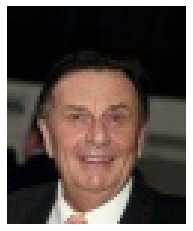

True Label:  tensor(1)
Model output:  tensor([-1.2891,  1.2893])
File name:  182356.jpg


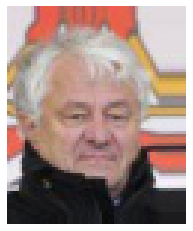

True Label:  tensor(0)
Model output:  tensor([ 1.2348, -1.2350])
File name:  178749.jpg


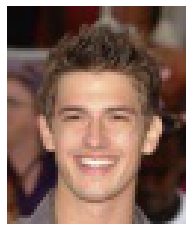

True Label:  tensor(1)
Model output:  tensor([-4.3422,  4.3424])
File name:  168980.jpg


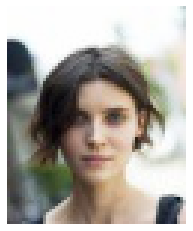

True Label:  tensor(0)
Model output:  tensor([ 1.7281, -1.7276])
File name:  163804.jpg


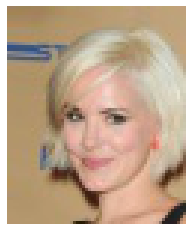

True Label:  tensor(1)
Model output:  tensor([-1.4739,  1.4744])
File name:  170250.jpg


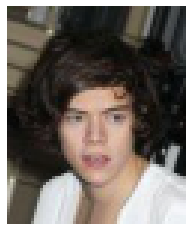

True Label:  tensor(0)
Model output:  tensor([ 2.1877, -2.1871])
File name:  176428.jpg


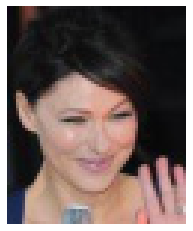

True Label:  tensor(1)
Model output:  tensor([-1.4180,  1.4184])
File name:  177387.jpg


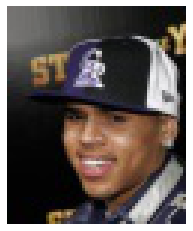

True Label:  tensor(1)
Model output:  tensor([-1.3952,  1.3951])
File name:  172000.jpg


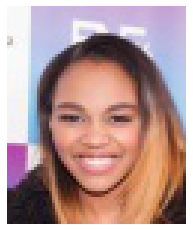

True Label:  tensor(1)
Model output:  tensor([-4.1277,  4.1280])
File name:  182444.jpg


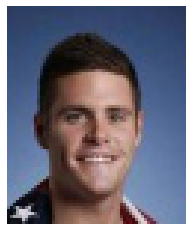

True Label:  tensor(1)
Model output:  tensor([-2.5882,  2.5886])
File name:  174614.jpg


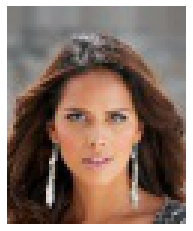

True Label:  tensor(0)
Model output:  tensor([ 0.3841, -0.3835])
File name:  170952.jpg


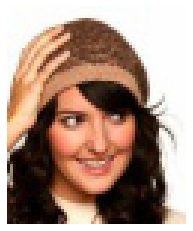

True Label:  tensor(1)
Model output:  tensor([-5.0810,  5.0812])
File name:  163651.jpg


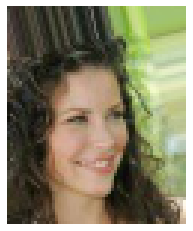

True Label:  tensor(1)
Model output:  tensor([-1.7260,  1.7262])
File name:  173489.jpg


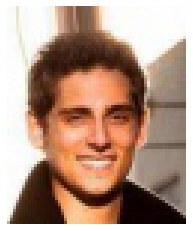

True Label:  tensor(1)
Model output:  tensor([-2.8914,  2.8914])
File name:  180879.jpg


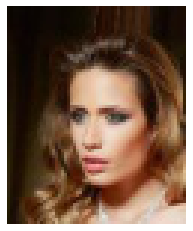

True Label:  tensor(0)
Model output:  tensor([ 2.3448, -2.3441])
File name:  163633.jpg


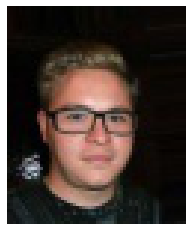

True Label:  tensor(0)
Model output:  tensor([ 1.5384, -1.5379])
File name:  166743.jpg


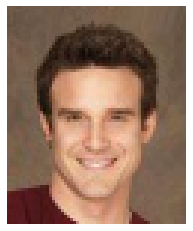

True Label:  tensor(1)
Model output:  tensor([-4.5254,  4.5257])
File name:  170590.jpg


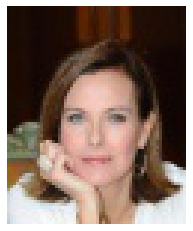

True Label:  tensor(0)
Model output:  tensor([ 1.2562, -1.2558])
File name:  177273.jpg


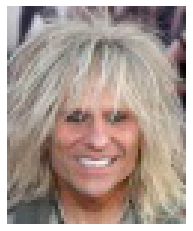

True Label:  tensor(1)
Model output:  tensor([-3.8380,  3.8380])
File name:  179745.jpg


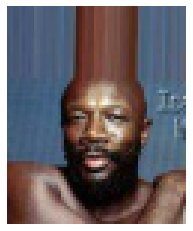

True Label:  tensor(0)
Model output:  tensor([ 1.6688, -1.6686])
File name:  174953.jpg


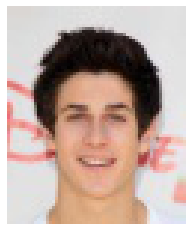

True Label:  tensor(1)
Model output:  tensor([-2.6315,  2.6319])
File name:  165985.jpg


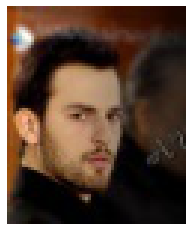

True Label:  tensor(0)
Model output:  tensor([ 1.5706, -1.5706])
File name:  170054.jpg


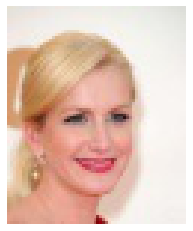

True Label:  tensor(1)
Model output:  tensor([-3.1431,  3.1434])
File name:  176722.jpg


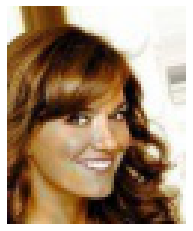

True Label:  tensor(1)
Model output:  tensor([-2.0934,  2.0935])
File name:  175013.jpg


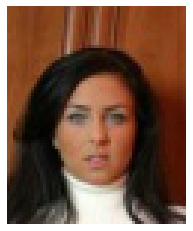

True Label:  tensor(0)
Model output:  tensor([ 2.4450, -2.4449])
File name:  180717.jpg


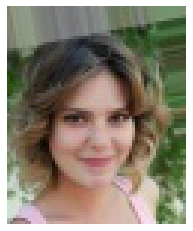

True Label:  tensor(1)
Model output:  tensor([-1.4080,  1.4083])
File name:  176479.jpg


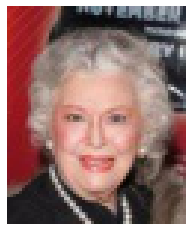

True Label:  tensor(1)
Model output:  tensor([-2.3984,  2.3987])
File name:  170380.jpg


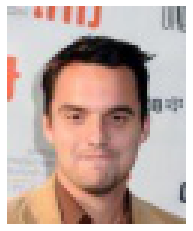

True Label:  tensor(1)
Model output:  tensor([ 0.5299, -0.5298])
File name:  164432.jpg


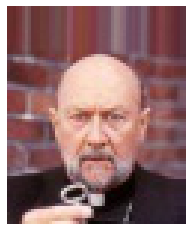

True Label:  tensor(0)
Model output:  tensor([ 2.4123, -2.4120])
File name:  166861.jpg


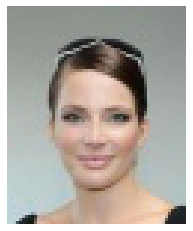

True Label:  tensor(1)
Model output:  tensor([-0.9952,  0.9956])
File name:  172127.jpg


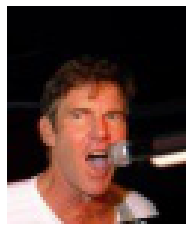

True Label:  tensor(0)
Model output:  tensor([ 2.2758, -2.2760])
File name:  181850.jpg


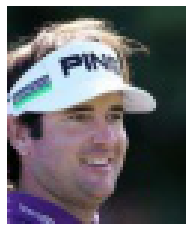

True Label:  tensor(1)
Model output:  tensor([-1.7894,  1.7894])
File name:  173981.jpg


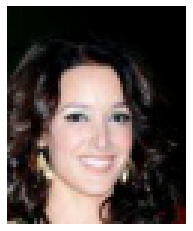

True Label:  tensor(1)
Model output:  tensor([-2.6885,  2.6885])
File name:  165486.jpg


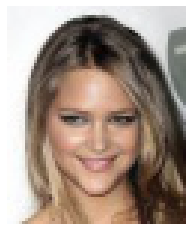

True Label:  tensor(1)
Model output:  tensor([-6.0983,  6.0987])
File name:  175451.jpg


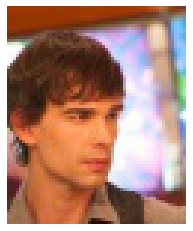

True Label:  tensor(0)
Model output:  tensor([ 2.1962, -2.1962])
File name:  167299.jpg


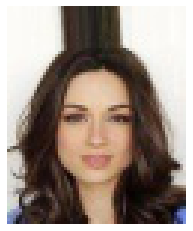

True Label:  tensor(0)
Model output:  tensor([-0.1500,  0.1502])
File name:  176440.jpg


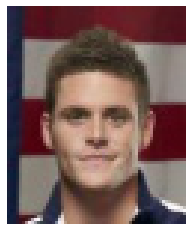

True Label:  tensor(0)
Model output:  tensor([ 0.5227, -0.5224])
File name:  176542.jpg


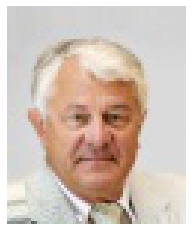

True Label:  tensor(0)
Model output:  tensor([ 0.2071, -0.2066])
File name:  178914.jpg


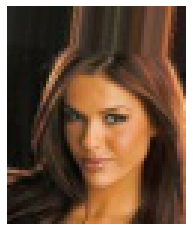

True Label:  tensor(0)
Model output:  tensor([ 0.3889, -0.3881])
File name:  163280.jpg


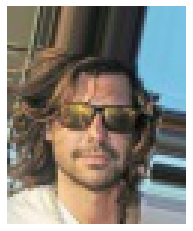

True Label:  tensor(0)
Model output:  tensor([ 0.8365, -0.8368])
File name:  169075.jpg


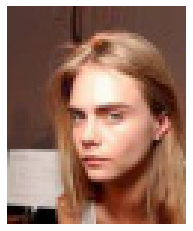

True Label:  tensor(0)
Model output:  tensor([ 2.9348, -2.9349])
File name:  182307.jpg


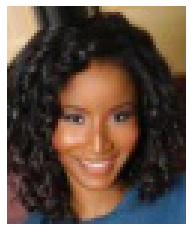

True Label:  tensor(1)
Model output:  tensor([-3.1013,  3.1011])
File name:  173582.jpg


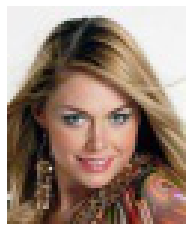

True Label:  tensor(1)
Model output:  tensor([-2.6673,  2.6678])
File name:  175952.jpg


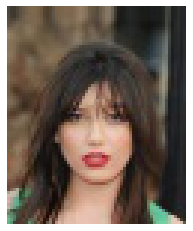

True Label:  tensor(0)
Model output:  tensor([ 1.7508, -1.7507])
File name:  176421.jpg


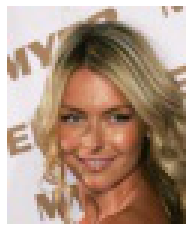

True Label:  tensor(1)
Model output:  tensor([-2.8665,  2.8670])
File name:  170978.jpg


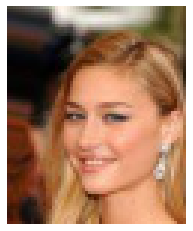

True Label:  tensor(1)
Model output:  tensor([-3.2736,  3.2741])
File name:  180993.jpg


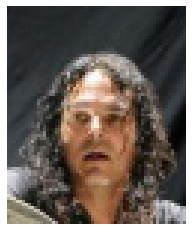

True Label:  tensor(0)
Model output:  tensor([ 2.2839, -2.2836])
File name:  169221.jpg


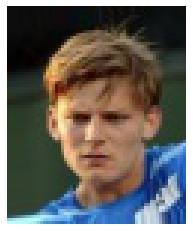

True Label:  tensor(0)
Model output:  tensor([ 3.6893, -3.6888])
File name:  167330.jpg


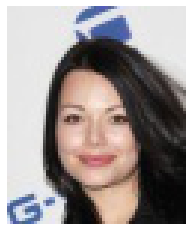

True Label:  tensor(1)
Model output:  tensor([-2.3629,  2.3634])
File name:  176055.jpg


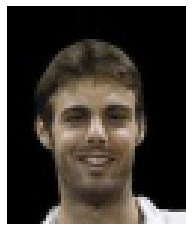

True Label:  tensor(1)
Model output:  tensor([-1.8760,  1.8762])
File name:  181345.jpg


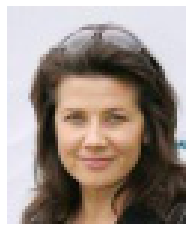

True Label:  tensor(1)
Model output:  tensor([-1.9244,  1.9247])
File name:  163075.jpg


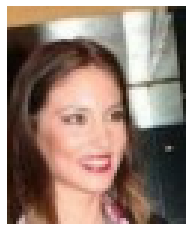

True Label:  tensor(1)
Model output:  tensor([-2.0084,  2.0085])
File name:  164690.jpg


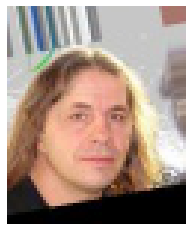

True Label:  tensor(0)
Model output:  tensor([ 1.5872, -1.5871])
File name:  173661.jpg


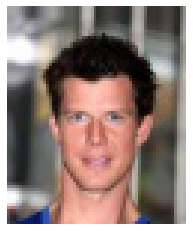

True Label:  tensor(0)
Model output:  tensor([-0.1402,  0.1407])
File name:  168537.jpg


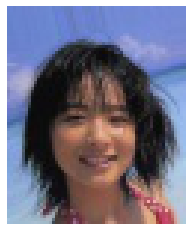

True Label:  tensor(1)
Model output:  tensor([-3.1221,  3.1223])
File name:  168886.jpg


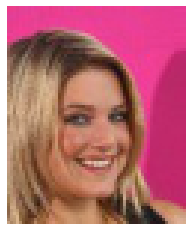

True Label:  tensor(1)
Model output:  tensor([-4.5525,  4.5523])
File name:  172404.jpg


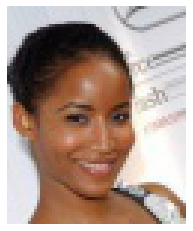

True Label:  tensor(1)
Model output:  tensor([-1.8729,  1.8730])
File name:  174863.jpg


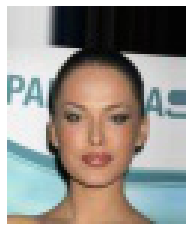

True Label:  tensor(0)
Model output:  tensor([ 1.4968, -1.4964])
File name:  163674.jpg


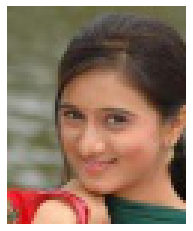

True Label:  tensor(1)
Model output:  tensor([-1.6732,  1.6734])
File name:  172091.jpg


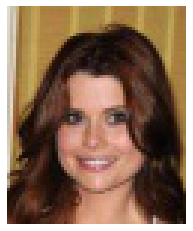

True Label:  tensor(1)
Model output:  tensor([-3.0259,  3.0263])
File name:  179573.jpg


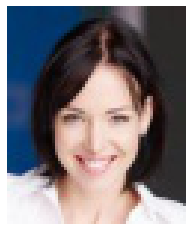

True Label:  tensor(1)
Model output:  tensor([-5.5851,  5.5853])
File name:  182322.jpg


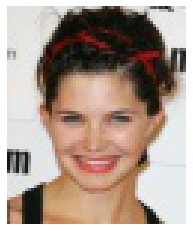

True Label:  tensor(1)
Model output:  tensor([-4.0928,  4.0931])
File name:  171805.jpg


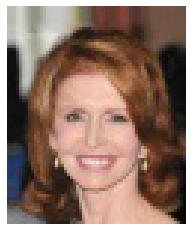

True Label:  tensor(1)
Model output:  tensor([-2.6238,  2.6241])
File name:  173613.jpg


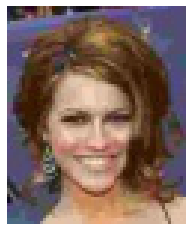

True Label:  tensor(1)
Model output:  tensor([-3.9095,  3.9097])
File name:  163648.jpg


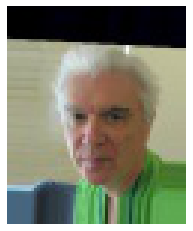

True Label:  tensor(0)
Model output:  tensor([ 1.5920, -1.5920])
File name:  178944.jpg


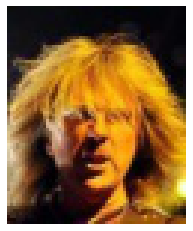

True Label:  tensor(0)
Model output:  tensor([ 1.4865, -1.4865])
File name:  179257.jpg


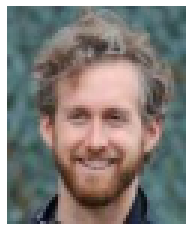

True Label:  tensor(1)
Model output:  tensor([-3.2044,  3.2044])
File name:  176531.jpg


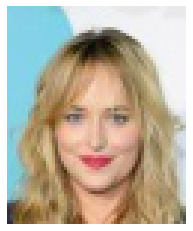

True Label:  tensor(1)
Model output:  tensor([-2.7830,  2.7834])
File name:  178315.jpg


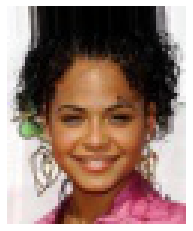

True Label:  tensor(1)
Model output:  tensor([-4.6564,  4.6564])
File name:  168227.jpg


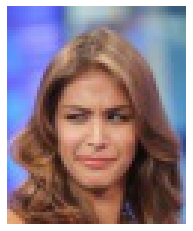

True Label:  tensor(1)
Model output:  tensor([-0.5879,  0.5881])
File name:  175957.jpg


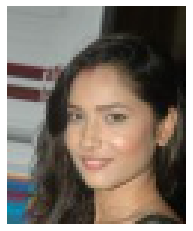

True Label:  tensor(1)
Model output:  tensor([-0.8980,  0.8984])
File name:  168399.jpg


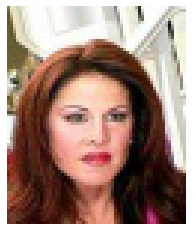

True Label:  tensor(0)
Model output:  tensor([ 1.5277, -1.5272])
File name:  175381.jpg


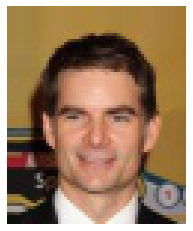

True Label:  tensor(1)
Model output:  tensor([-2.3069,  2.3073])
File name:  169807.jpg


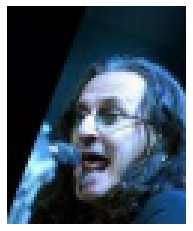

True Label:  tensor(0)
Model output:  tensor([ 0.6498, -0.6497])
File name:  170680.jpg


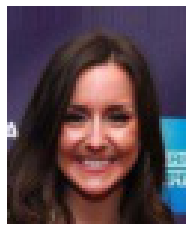

True Label:  tensor(1)
Model output:  tensor([-4.4560,  4.4559])
File name:  171956.jpg


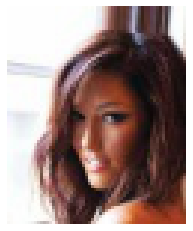

True Label:  tensor(1)
Model output:  tensor([-0.2107,  0.2109])
File name:  167356.jpg


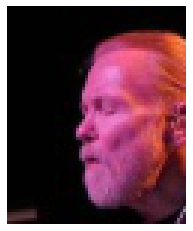

True Label:  tensor(0)
Model output:  tensor([ 0.7109, -0.7107])
File name:  165902.jpg


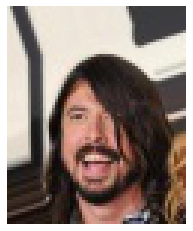

True Label:  tensor(1)
Model output:  tensor([-2.2705,  2.2704])
File name:  165027.jpg


In [42]:
#calculation predictions on the validation set
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
val_1_losses,val_1_accs,val_1_lengths,val_0_losses,val_0_accs,val_0_lengths = 0, 0, 0, 0, 0, 0
valid_predictions = valid_predictions.astype(object)
j=0
with torch.no_grad():
    for batch_valid in batch_gen_valid:
        
        output = net(**get_input(batch_valid))
        labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
        if j == 2:
            break
        j+=1
        for i in range(len(batch_valid['file'])):
            plt.figure()
            plt.imshow(np.transpose(vutils.make_grid(batch_valid['image'][i], padding=2,normalize=True).cpu(),(1,2,0)))
            plt.axis('off')
            plt.ioff()
            plt.show()
            print('True Label: ',labels_argmax[i]) 
            print('Model output: ', output['out'][i])
            print('File name: ', batch_valid['file'][i])
            valid_predictions.at[batch_valid['file'][i],'output'] = output['out'][i]
            valid_predictions.at[batch_valid['file'][i],'labels_argmax'] = labels_argmax[i]
            valid_predictions.at[batch_valid['file'][i],'accuracy'] = accuracy(output['out'][i:i+1],labels_argmax[i:i+1])
            valid_predictions.at[batch_valid['file'][i],'criterion'] = criterion(output['out'][i:i+1],labels_argmax[i:i+1])

In [43]:
# Should be equalt to validation accuracy in df
np.mean(valid_predictions['accuracy'])

0.93359375

In [44]:
#calculating accuracies for all protected attributes
attributes = matched.iloc[:,0:-1].drop('Smiling',axis=1).columns
df_att = pd.DataFrame(index = attributes, columns=['val_1_loss','val_1_acc','val_0_loss','val_0_acc','val_1_FP','val_1_TP','val_0_FP','val_0_TP','val_1_FN','val_0_FN'])
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
for att in range(0,len(attributes)):
    print(attributes[att])
    
    att_ = valid_predictions.iloc[:][attributes[att]]
    t_ = valid_predictions.iloc[:]['target']
    
    att_1 = np.where(att_==1)
    att_0 = np.where(att_==0)
    
    att_1_t_1 = np.where((att_==1) & (t_==1))
    att_0_t_1 = np.where((att_==0) & (t_==1))
    att_1_t_0 = np.where((att_==1) & (t_==0))
    att_0_t_0 = np.where((att_==0) & (t_==0))
    
    df_att.iloc[att]['val_1_loss'] = np.mean(valid_predictions.iloc[att_1]['criterion'])
    df_att.iloc[att]['val_1_acc'] = np.mean(valid_predictions.iloc[att_1]['accuracy'])
    df_att.iloc[att]['val_0_loss'] = np.mean(valid_predictions.iloc[att_0]['criterion'])
    df_att.iloc[att]['val_0_acc'] = np.mean(valid_predictions.iloc[att_0]['accuracy'])
    df_att.iloc[att]['val_1_FP'] = 1-np.mean(valid_predictions.iloc[att_1_t_0]['accuracy'])
    df_att.iloc[att]['val_0_FP'] = 1-np.mean(valid_predictions.iloc[att_0_t_0]['accuracy'])
    df_att.iloc[att]['val_1_TP'] = np.mean(valid_predictions.iloc[att_1_t_1]['accuracy'])
    df_att.iloc[att]['val_0_TP'] = np.mean(valid_predictions.iloc[att_0_t_1]['accuracy'])
    df_att.iloc[att]['val_1_FN'] = 1-np.mean(valid_predictions.iloc[att_1_t_1]['accuracy'])
    df_att.iloc[att]['val_0_FN'] = 1-np.mean(valid_predictions.iloc[att_0_t_1]['accuracy'])

5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


In [45]:
df_att['TP_OR'] = df_att['val_1_TP'] /df_att['val_0_TP'] 
df_att['FP_OR'] = df_att['val_1_FP'] /df_att['val_0_FP']
df_att['acc_ratio'] = df_att['val_1_acc'] /df_att['val_0_acc']
df_att['FN_OR'] = df_att['val_1_FN'] /df_att['val_0_FN'] 
df_att['TP_OR'] = pd.to_numeric(df_att['TP_OR'])
df_att['FP_OR'] = pd.to_numeric(df_att['FP_OR'])
df_att['acc_ratio'] = pd.to_numeric(df_att['acc_ratio'])
df_att['FN_OR'] = pd.to_numeric(df_att['FN_OR'])


In [46]:
df_att = df_att.sort_values('acc_ratio')

In [47]:
df_att

val_1_loss val_1_acc val_0_loss val_0_acc   val_1_FP  \
Double_Chin           0.460059     0.875   0.163643    0.9375       0.25   
Wavy_Hair             0.223533  0.888889   0.165983  0.951087   0.208333   
Black_Hair            0.198598  0.892857   0.177569     0.945   0.137931   
Young                 0.182992  0.920635   0.179846  0.970149    0.10989   
Bushy_Eyebrows         0.13829  0.897436   0.190055  0.940092   0.142857   
Male                  0.254124  0.910714   0.126204  0.951389  0.0945946   
Wearing_Hat           0.435288       0.9    0.17188  0.934959   0.166667   
5_o_Clock_Shadow      0.262497  0.914286   0.169447  0.936652        0.1   
Straight_Hair         0.190316  0.918033    0.17962  0.938462        0.1   
Brown_Hair            0.184473  0.923077   0.181385  0.937173   0.103448   
Gray_Hair             0.316041  0.923077   0.175007  0.934156   0.111111   
Blurry                0.329764  0.923077   0.174273  0.934156   0.142857   
Oval_Face             0.197933  0.928571   0.176236  0.935484  0.0714286   
Chubby                0.362309  0.928571   0.171748  0.933884          0   
Bags_Under_Eyes       0.260387  0.932203   0.158743   0.93401  0.0909091   
Sideburns             0.177451    0.9375   0.182484  0.933333  0.0833333   
Attractive            0.154984    0.9375   0.217121  0.928571  0.0892857   
No_Beard               0.17635  0.935185   0.213594     0.925   0.111111   
Wearing_Lipstick        0.1403  0.941176   0.218537  0.927007   0.138889   
Heavy_Makeup          0.144214  0.942308   0.208138  0.927632   0.114286   
Pointy_Nose            0.13238      0.95     0.2048  0.926136    0.09375   
Mouth_Slightly_Open   0.146289  0.945736   0.218614   0.92126   0.222222   
Narrow_Eyes           0.122375  0.956522   0.188071   0.93133       0.25   
Blond_Hair            0.160916  0.966667    0.18499  0.929204          0   
Wearing_Necklace      0.111461  0.967742   0.191911  0.928889  0.0769231   
Big_Nose              0.159143  0.967213   0.189372  0.923077   0.037037   
Big_Lips              0.107804   0.97561    0.19635  0.925581  0.0526316   
Arched_Eyebrows      0.0910781  0.971014    0.21578  0.919786  0.0769231   
Wearing_Earrings     0.0916885  0.976744   0.200435  0.924883  0.0769231   
Bald                 0.0319548         1    0.18395  0.932806          0   
Pale_Skin             0.127925         1   0.183471     0.932          0   
Mustache             0.0934241         1   0.185777  0.930894          0   
Eyeglasses            0.188303         1   0.181894  0.930612          0   
Wearing_Necktie      0.0723447         1   0.188044  0.930041          0   
Receding_Hairline    0.0471642         1   0.192992   0.92827          0   
Goatee                0.131624         1   0.186221   0.92827          0   
Rosy_Cheeks          0.0376358         1   0.196436  0.927039          0   
Bangs                0.0572075         1   0.197515  0.925439          0   
High_Cheekbones       0.091557     0.984   0.268631  0.885496          0   

                     val_1_TP   val_0_FP  val_0_TP    val_1_FN   val_0_FN  \
Double_Chin                 1  0.0840336  0.958678           0  0.0413223   
Wavy_Hair              0.9375  0.0679612  0.975309      0.0625  0.0246914   
Black_Hair           0.925926  0.0816327  0.970588   0.0740741  0.0294118   
Young                 0.94898  0.0555556         1   0.0510204          0   
Bushy_Eyebrows       0.944444  0.0849057  0.963964   0.0555556   0.036036   
Male                 0.921053  0.0943396  0.978022   0.0789474   0.021978   
Wearing_Hat                 1  0.0909091      0.96           0       0.04   
5_o_Clock_Shadow     0.933333  0.0934579  0.964912   0.0666667  0.0350877   
Straight_Hair        0.935484  0.0927835  0.969388   0.0645161  0.0306122   
Brown_Hair           0.944444  0.0918367  0.967742   0.0555556  0.0322581   
Gray_Hair                   1  0.0932203      0.96           0       0.04   
Blurry                      1  0.0916667   0.95935     

In [48]:
df_att2 = df_att.loc[['Rosy_Cheeks','Gray_Hair','Mustache','Sideburns','Arched_Eyebrows','Attractive','Bags_Under_Eyes','Bald','Bangs','Big_Lips','Big_Nose','Chubby','Double_Chin','Heavy_Makeup','Eyeglasses','Goatee','High_Cheekbones','Pale_Skin','Male','Mouth_Slightly_Open','Young']].sort_values('acc_ratio')

In [49]:
df_att2[['acc_ratio','FN_OR','FP_OR']]

acc_ratio     FN_OR     FP_OR
Double_Chin           0.933333  0.000000  2.975000
Young                 0.948962       inf  1.978022
Male                  0.957247  3.592105  1.002703
Gray_Hair             0.988140  0.000000  1.191919
Chubby                0.994311  4.357143  0.000000
Bags_Under_Eyes       0.998066  1.657658  0.954545
Sideburns             1.004464  0.000000  0.871212
Attractive            1.009615  1.863636  0.905612
Heavy_Makeup          1.015821  0.579710  1.314286
Mouth_Slightly_Open   1.026569  0.066176  3.703704
Big_Nose              1.047814  0.698529  0.336700
Big_Lips              1.054051  0.000000  0.516746
Arched_Eyebrows       1.055696  0.000000  0.776923
Bald                  1.072034  0.000000  0.000000
Pale_Skin             1.072961  0.000000  0.000000
Mustache              1.074236  0.000000  0.000000
Eyeglasses            1.074561  0.000000  0.000000
Goatee                1.077273  0.000000  0.000000
Rosy_Cheeks           1.078704  0.000000  0.000000
Bangs                 1.080569  0.000000  0.000000
High_Cheekbones       1.111241  0.094395  0.000000

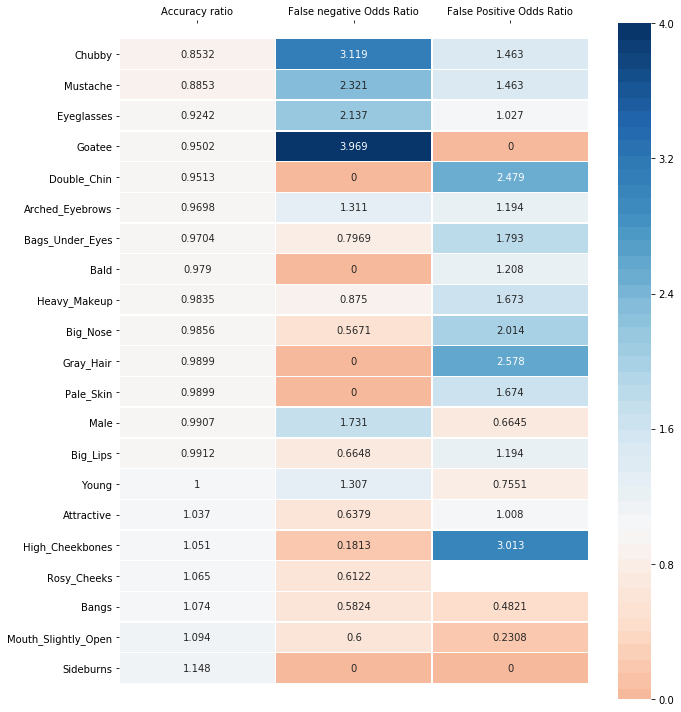

In [25]:
plt.figure(figsize = (10,10))
cmap=sns.color_palette("RdBu",70)
heatmap_kwargs = dict(vmin=0, vmax=4, cmap=cmap,annot=True, linewidths=.5, fmt='.4g')
ax = sns.heatmap(df_att2[['acc_ratio','FN_OR','FP_OR']], center=1.0, **heatmap_kwargs)
ax.set_xticklabels(['Accuracy ratio','False negative Odds Ratio','False Positive Odds Ratio'])
ax.set_yticklabels(list(df_att2.index))
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.xaxis.set_ticks_position('top')
plt.tight_layout()
plt.savefig('heat.png',dpi=500)

In [ ]:
#funtion to show image along with output and tru target
def show_batch(sample_batched, bias_idx):
    """Show image with landmarks for a batch of samples."""
    images_batch, target_batch, bias = \
            sample_batched['image'], sample_batched['target'], sample_batched['attributes'][:,bias_idx]
    
    batch_size = len(images_batch)
    pred_label = torch.max(get_labels(sample_batched), 1)[1]
    
    for i in range(batch_size):

        #grid = utils.make_grid(images_batch)
        plt.figure()
        plt.imshow(np.transpose(vutils.make_grid(images_batch[i], padding=2,normalize=True).cpu(),(1,2,0)))
        plt.axis('off')
        plt.ioff()
        plt.show()
        print(target_batch[i])
        #print(bias[i])
        print('Output of NN: ',output['out'][i])
        print('Predicted label: ', pred_label[i])

In [ ]:
batch_valid

In [ ]:
plt.figure()
show_batch(batch_valid,21)
plt.axis('off')
plt.ioff()
plt.show()

In [ ]:
IMAGE_SHAPE = [73,60,3]
# Root directory for dataset
dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'
# Paths to data
VALID_PATH = dataroot + "\\images_resize\\valid.csv"  
IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\images_resize"
TARGET_COL = 'Smiling' #'Smiling'
NUM_CLASSES = 2

# valid data
data_valid = data_utils.CelebADataset(VALID_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

In [ ]:
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
with torch.no_grad():
    for batch_valid in batch_gen_valid:
        output = net(**get_input(batch_valid))
        labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
        ac = accuracy(output['out'],labels_argmax)
        print(ac)

In [ ]:
output

In [ ]:
batch_valid